# Regression example with a neural network

## MLPRegressor

It turns out that the simple MLPRegressor in Scikit-Learn works very well on small datasets.

In [1]:
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [10]:
with gzip.open("rec_hist_pt_25.pkl.gz") as f:
    rec = pickle.load(f)

with gzip.open("gen_hist_pt_25.pkl.gz") as f:
    gen = pickle.load(f)

rec = rec[:,:,:,:,:]
gen = gen[:,:,:,:,:]
# fix for divide by zero
gen.values()[gen.values() == 0] = 1

n = gen.values()
ns = rec.values()
# fix for rec > n
ns = np.where(ns > n, n, ns)
nf = n - ns

eff = ns / n

z = 1
sigma_eff = z/(n + z ** 2) * np.sqrt(ns * nf / (n + 1e-8) + z ** 2 / 4)

X = []
y = []
w = []
for ieta, eta in enumerate(rec.axes[0].centers):
    for ipt, pt in enumerate(rec.axes[1].centers):
        for iphi, phi in enumerate(rec.axes[2].centers):
            for ich, _ in enumerate(rec.axes[3]):
                for isp, _ in enumerate(rec.axes[4]):
                    X.append((eta, np.log(pt), np.cos(phi), np.sin(phi), ich, isp))
                    y.append(eff[ieta, ipt, iphi, ich, isp])
                    w.append(1/sigma_eff[ieta, ipt, iphi, ich, isp])

X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.float32)
w = np.array(w).astype(np.float32)

print("data points", X.shape[0])

data points 14400


In [16]:
# scikit-learn
net = MLPRegressor(
    hidden_layer_sizes=(2**6,) * 5,
    batch_size=100,
    alpha=0,
    tol=1e-6,
    max_iter=10000,
    verbose=1,
)

clf = make_pipeline(StandardScaler(), net)

clf.fit(X, y)

n = 0
for c in net.coefs_:
    n += np.prod(c.shape)
for c in net.intercepts_:
    n += c.shape[0]
print("number of parameters", n)

Iteration 1, loss = 0.01969663
Iteration 2, loss = 0.00350687
Iteration 3, loss = 0.00245632
Iteration 4, loss = 0.00197593
Iteration 5, loss = 0.00175609
Iteration 6, loss = 0.00164544
Iteration 7, loss = 0.00140919
Iteration 8, loss = 0.00131983
Iteration 9, loss = 0.00112184
Iteration 10, loss = 0.00110707
Iteration 11, loss = 0.00102675
Iteration 12, loss = 0.00096240
Iteration 13, loss = 0.00097759
Iteration 14, loss = 0.00093621
Iteration 15, loss = 0.00090874
Iteration 16, loss = 0.00086325
Iteration 17, loss = 0.00086946
Iteration 18, loss = 0.00092021
Iteration 19, loss = 0.00082390
Iteration 20, loss = 0.00085494
Iteration 21, loss = 0.00085404
Iteration 22, loss = 0.00083000
Iteration 23, loss = 0.00077776
Iteration 24, loss = 0.00078585
Iteration 25, loss = 0.00075060
Iteration 26, loss = 0.00074855
Iteration 27, loss = 0.00074264
Iteration 28, loss = 0.00074757
Iteration 29, loss = 0.00072960
Iteration 30, loss = 0.00074463
Iteration 31, loss = 0.00076818
Iteration 32, los

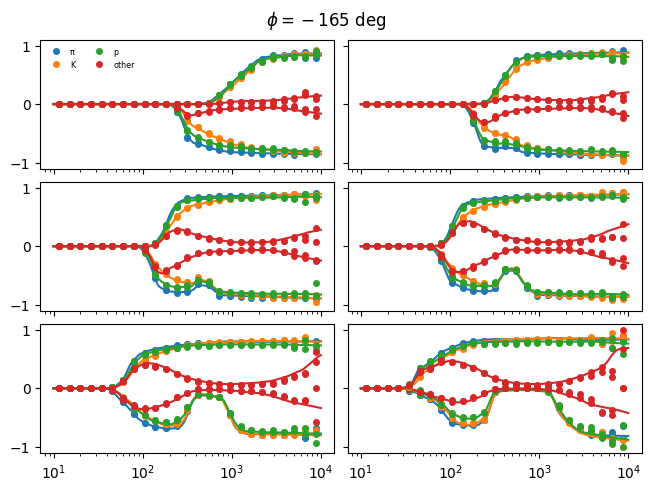

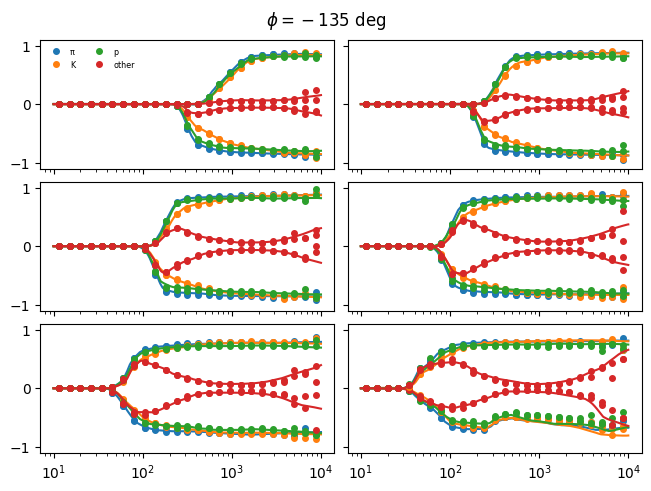

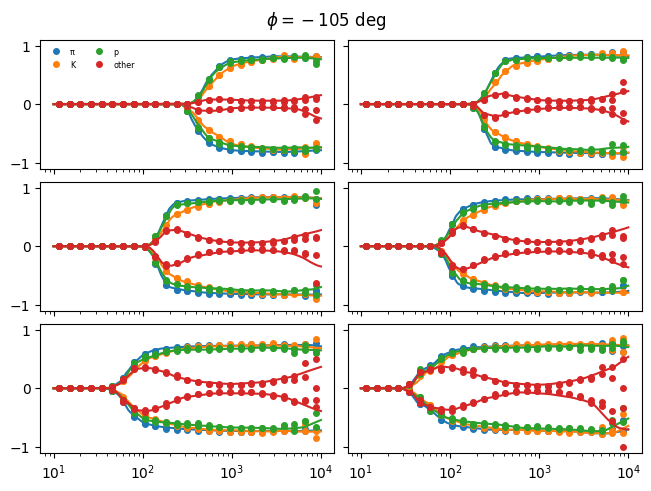

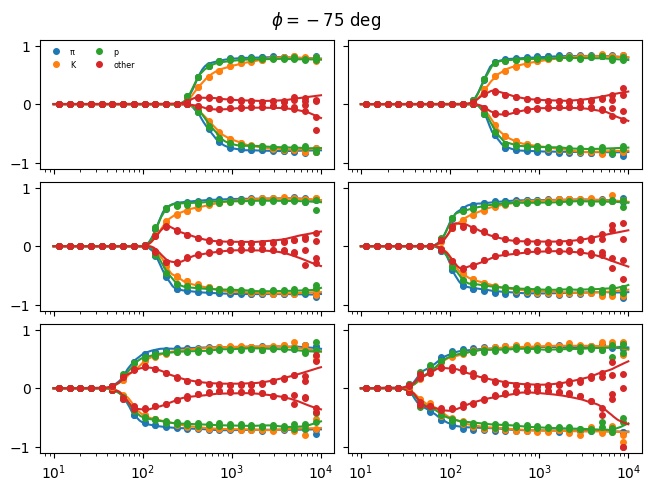

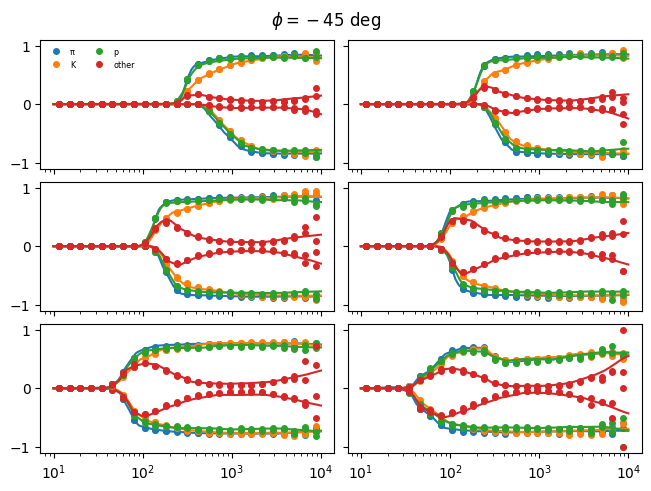

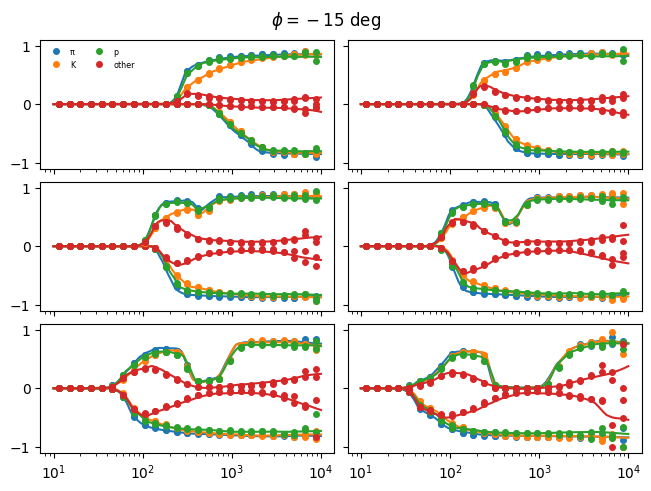

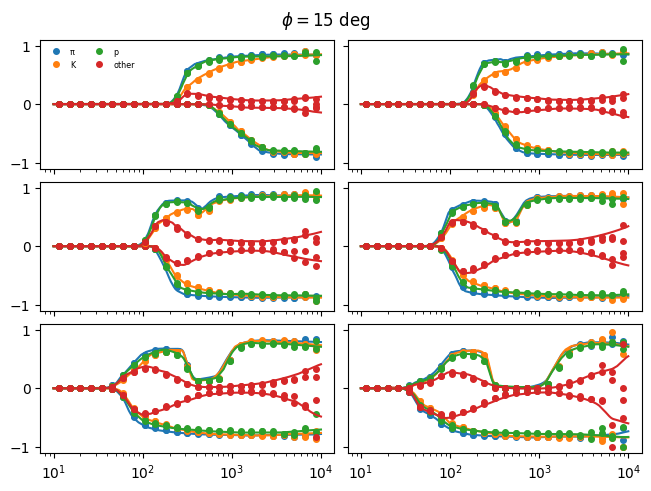

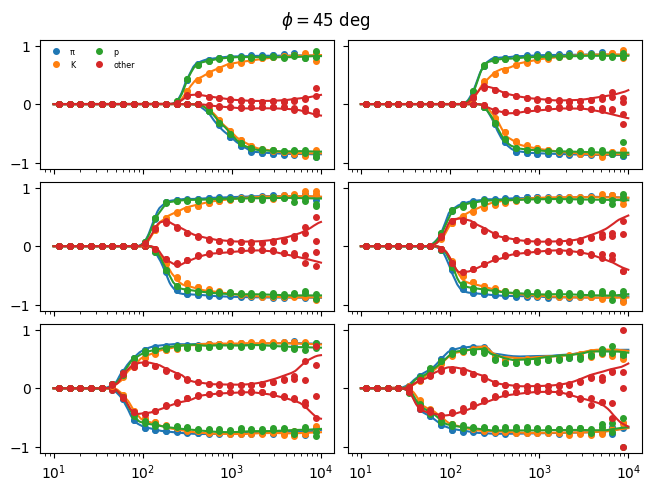

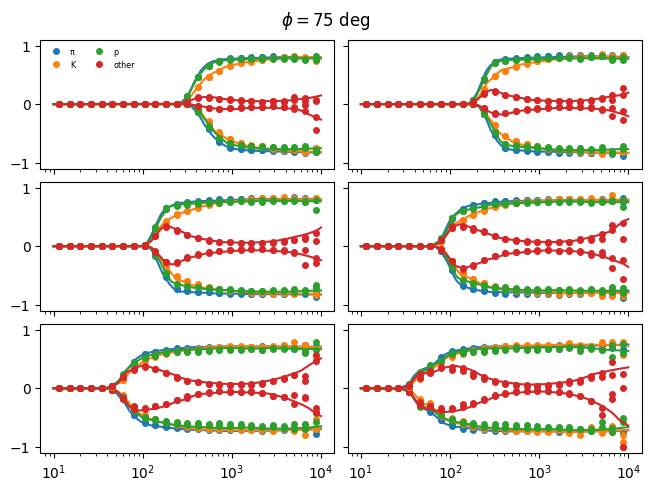

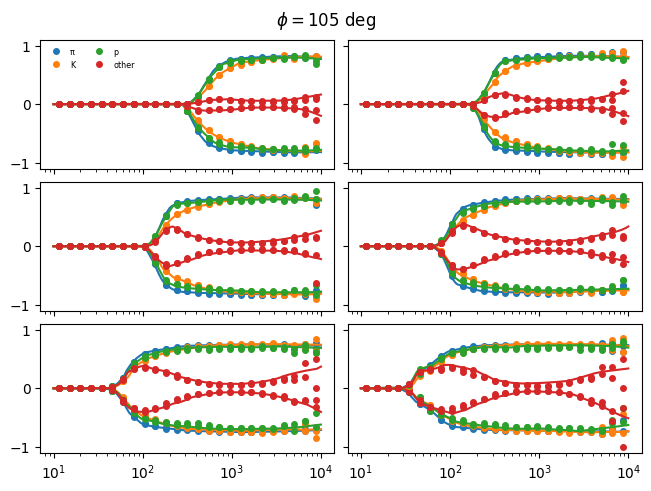

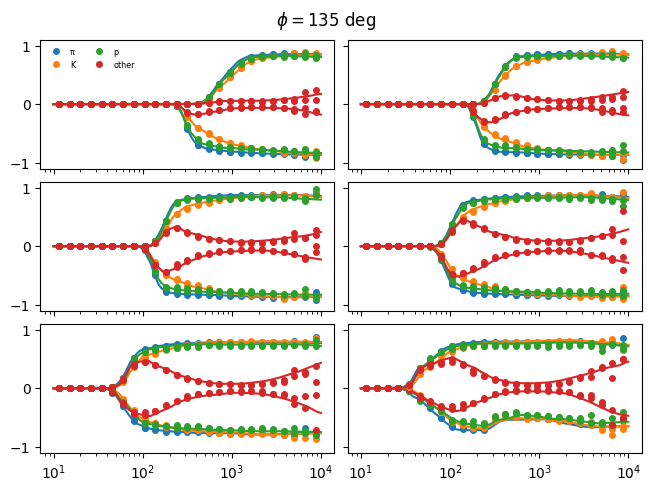

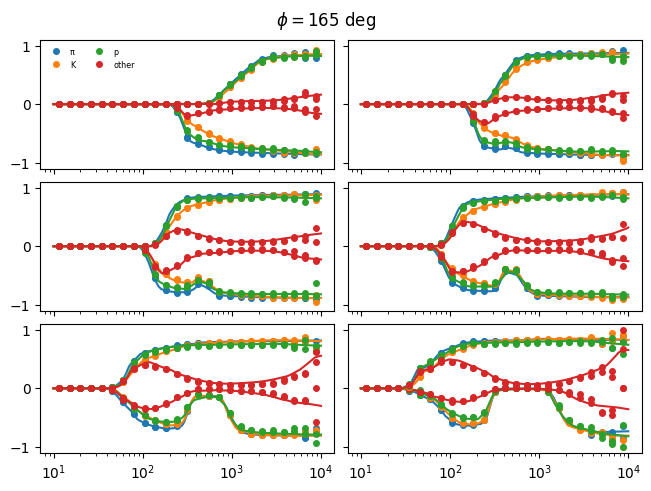

In [18]:
labels = ("π", "K", "p", "other")
for phii in rec.axes[2].centers:
    fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, layout="compressed")
    plt.suptitle(rf"$\phi = {np.degrees(phii):.0f}$ deg")
    for etai, axi in zip(rec.axes[0].centers, axes.flat):
        plt.sca(axi)
        for ich, charge in enumerate((-1, 1)):
            for isp, label in enumerate(labels):
                ma = X[:, 0] == etai
                ma &= np.abs(X[:, 2] - np.cos(phii)) < 0.001
                ma &= X[:, 4] == ich
                ma &= X[:, 5] == isp
                plt.plot(np.exp(X[ma, 1]), charge * y[ma], "o", ms=4, color=f"C{isp}", label=f"{label}" if ich else None)

                mpt = np.geomspace(10, 1e4, 2000)
                Xp = np.empty((len(mpt), 6), dtype=np.float32)
                Xp[:, 0] = etai
                Xp[:, 1] = np.log(mpt)
                Xp[:, 2] = np.cos(phii)
                Xp[:, 3] = np.sin(phii)
                Xp[:, 4] = ich
                Xp[:, 5] = isp
                yp = clf.predict(Xp)
                plt.plot(np.exp(Xp[:, 1]), charge * yp, color=f"C{isp}")
    plt.sca(axes[0,0])
    plt.semilogx()
    plt.ylim(-1.1, 1.1)
    plt.legend(fontsize="xx-small", ncol=2, frameon=False);

## PyTorch

99 0.042708322405815125
199 0.01998215913772583
299 0.011232716962695122
399 0.008756360039114952
499 0.007278420962393284
Epoch 00548: reducing learning rate of group 0 to 5.0000e-04.
599 0.0061150211840868
699 0.005621188320219517
799 0.005188740324229002
899 0.0047869691625237465
Epoch 00953: reducing learning rate of group 0 to 2.5000e-04.
999 0.004531166981905699
1099 0.004378164187073708
1199 0.004239027388393879
1299 0.0041046892292797565
1399 0.003948756959289312
1499 0.003787452122196555
Epoch 01596: reducing learning rate of group 0 to 1.2500e-04.
1599 0.003651263192296028
1699 0.003580793971195817
1799 0.0035129550378769636
1899 0.003440861590206623
1999 0.0033577808644622564
2099 0.003263862105086446
2199 0.0031417228747159243
2299 0.0030465908348560333
2399 0.0029477830976247787
2499 0.002853518119081855
2599 0.0027619516476988792
2699 0.002681383630260825
2799 0.0026106485165655613
2899 0.002544627757743001
2999 0.0024836501106619835
Epoch 03096: reducing learning rate of

[]

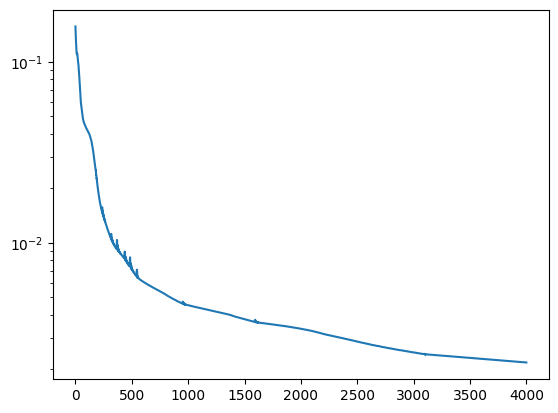

In [55]:
import torch
from torch import nn
import copy

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)

nonlin = nn.PReLU()
num = 2 ** 5
model = nn.Sequential(
    nn.Linear(6, num),
    nonlin,
    nn.Linear(num, num),
    nonlin,
    nn.Linear(num, num),
    nonlin,
    nn.Linear(num, num),
    nonlin,
    nn.Linear(num, num),
    nonlin,
    nn.Linear(num, num),
    nonlin,
    nn.Linear(num, 1),
    nonlin,
    nn.Flatten(0, 1),
)

# must make copies here
X_train = torch.tensor(X.copy())
w_train = torch.tensor(w.copy())
y_train = torch.tensor(y.copy())

max_epoch = 4000
patience = 10
learning_rate = 1e-3
batch = 200

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=patience, factor=0.5, verbose=True)
# opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.CyclicLR(opt, 1e-5, 1e-1)

def train_one_epoch(epoch):
    running_loss = 0.
    nbatch = len(y_train) // batch 
    for i in range(nbatch):
        sl = slice(i * batch, (i + 1) * batch)
        X_batch = X_train[sl]
        y_batch = y_train[sl]

        opt.zero_grad()

        y_pred = model(X_batch)

        # Compute the loss and its gradients
        loss = loss_fn(y_pred, y_batch)
        loss.backward()

        # Adjust learning weights
        opt.step()

        # Gather data and report
        running_loss += loss.item()
    return running_loss

losses = []
tol = 1e-6
patience_count = 0
prev_lo = np.inf
for epoch in range(max_epoch):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    losses.append(loss.item())
    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    loss = loss.item()
    if epoch % 100 == 99:
        print(epoch, loss)

    if loss - prev_lo < tol:
        patience_count = 0
    else:
        patience_count += 1
    if patience_count > patience:
        break

plt.plot(losses);
plt.semilogy()

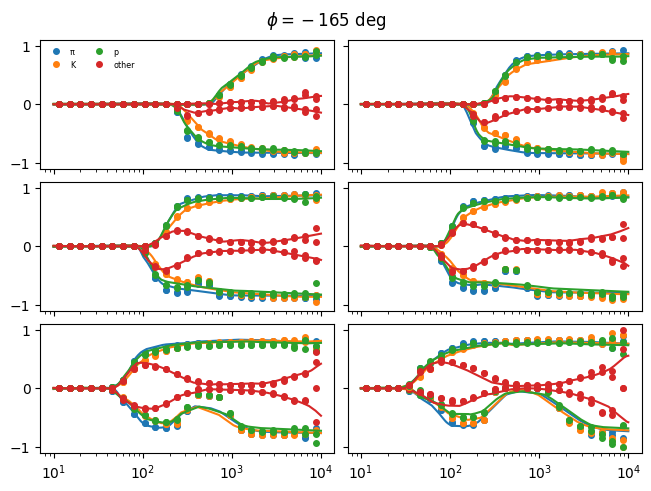

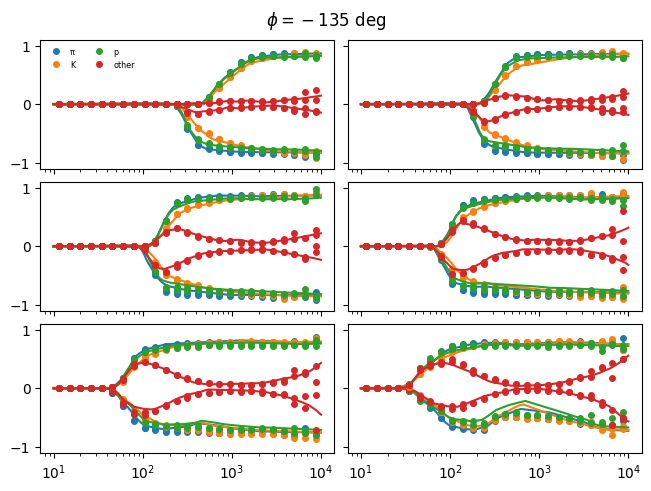

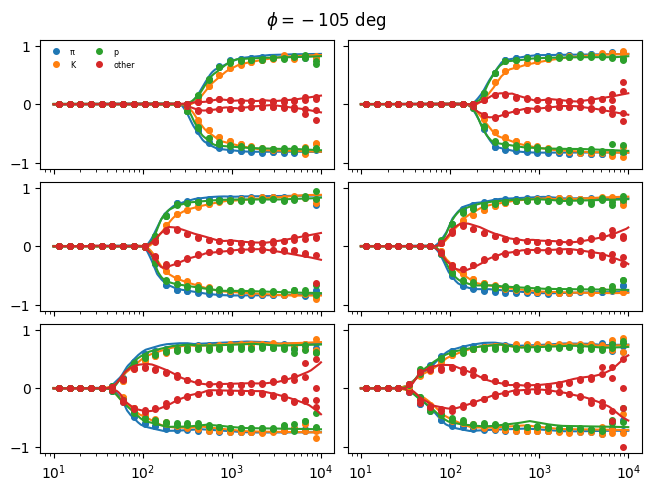

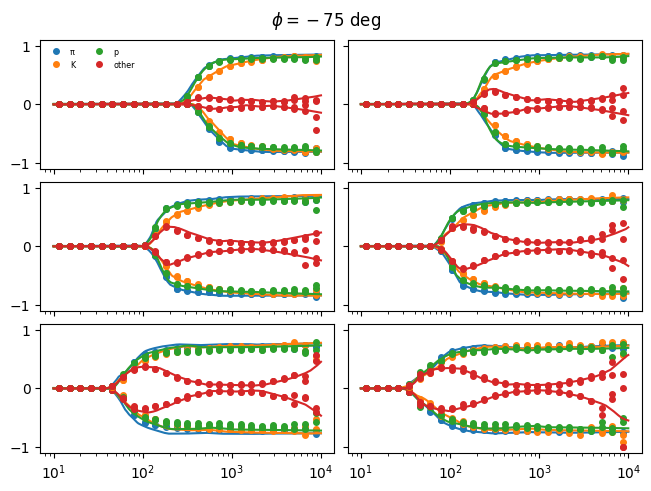

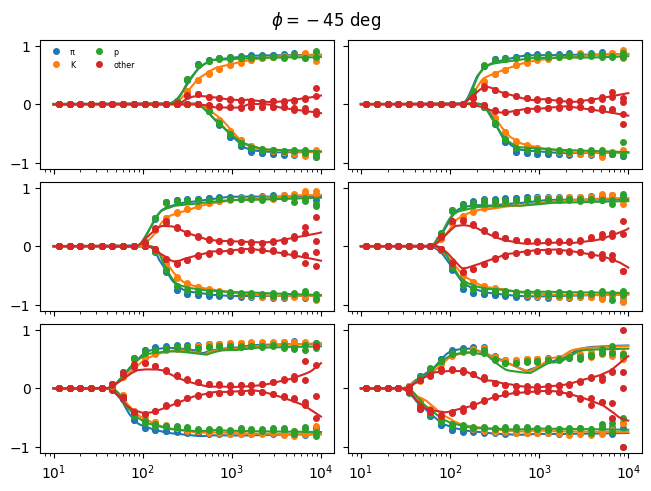

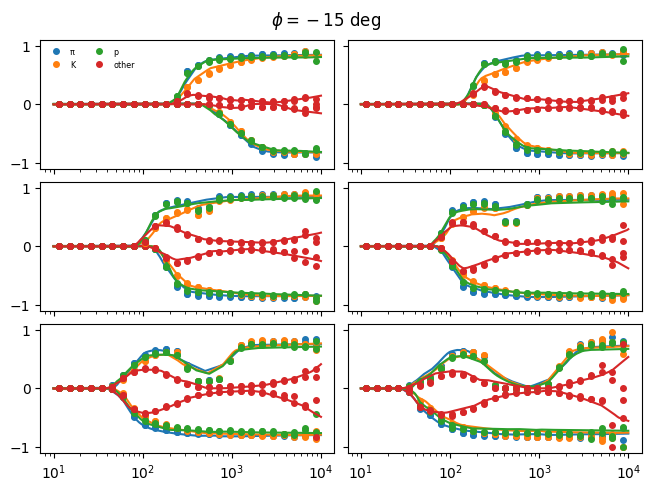

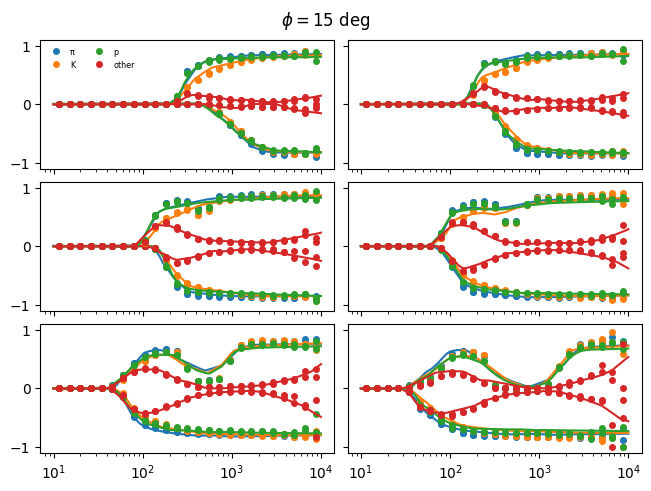

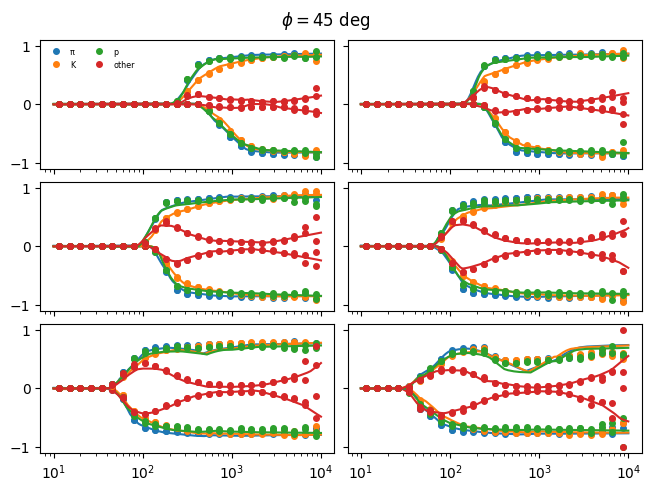

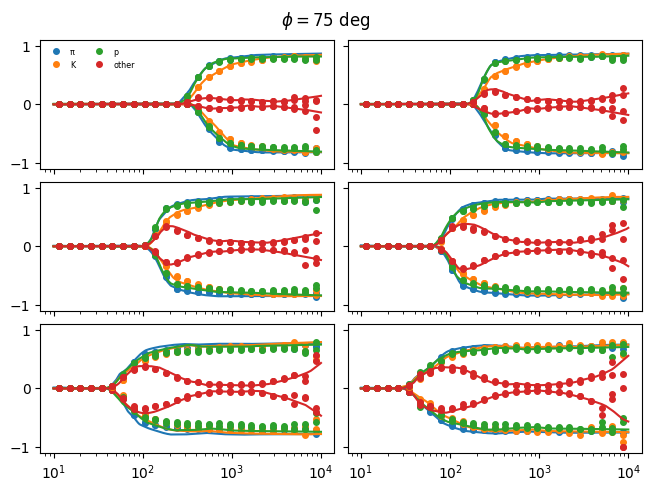

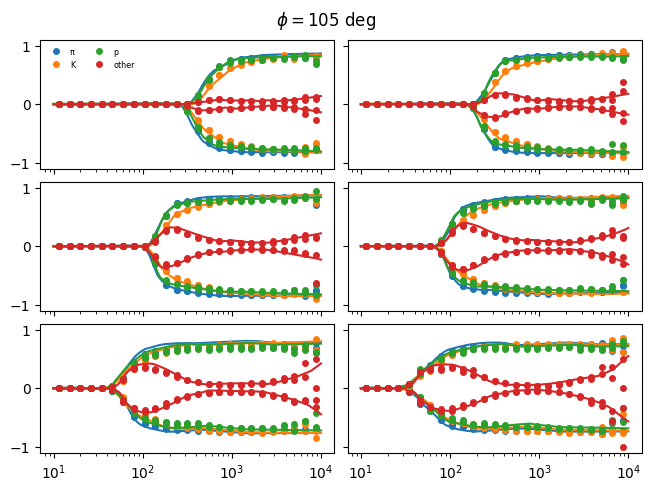

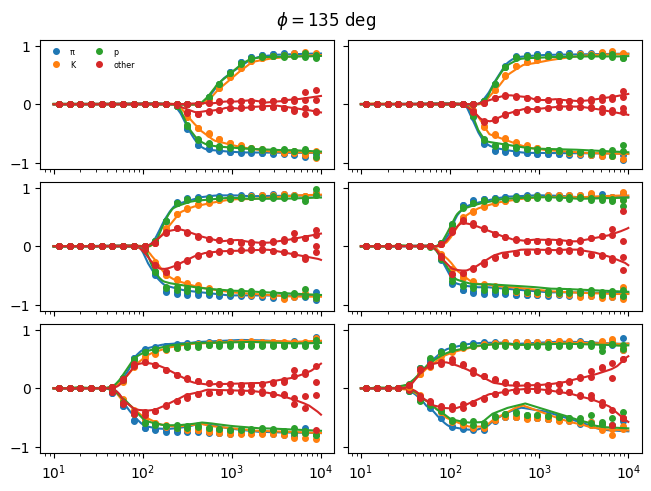

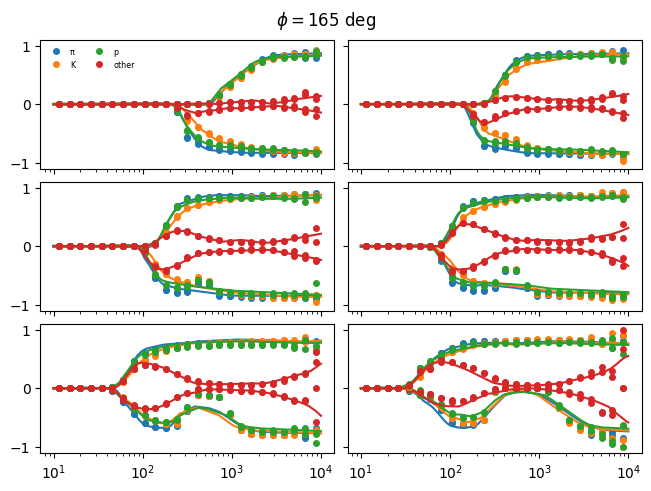

In [56]:
labels = ("π", "K", "p", "other")
for phii in rec.axes[2].centers:
    fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, layout="compressed")
    plt.suptitle(rf"$\phi = {np.degrees(phii):.0f}$ deg")
    for etai, axi in zip(rec.axes[0].centers, axes.flat):
        plt.sca(axi)
        for ich, charge in enumerate((-1, 1)):
            for isp, label in enumerate(labels):
                ma = X[:, 0] == etai
                ma &= np.abs(X[:, 2] - np.cos(phii)) < 0.001
                ma &= X[:, 4] == ich
                ma &= X[:, 5] == isp
                plt.plot(np.exp(X[ma, 1]), charge * y[ma], "o", ms=4, color=f"C{isp}", label=f"{label}" if ich else None)

                mpt = np.geomspace(10, 1e4, 2000)
                Xp = np.empty((len(mpt), 6), dtype=np.float32)
                Xp[:, 0] = etai
                Xp[:, 1] = np.log(mpt)
                Xp[:, 2] = np.cos(phii)
                Xp[:, 3] = np.sin(phii)
                Xp[:, 4] = ich
                Xp[:, 5] = isp
                yp = model(torch.tensor(Xp)).detach().numpy()
                plt.plot(np.exp(Xp[:, 1]), charge * yp, color=f"C{isp}")
    plt.sca(axes[0,0])
    plt.semilogx()
    plt.ylim(-1.1, 1.1)
    plt.legend(fontsize="xx-small", ncol=2, frameon=False);